In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, lit, count, avg, when
from pyspark.ml.feature import StringIndexer




In [ ]:

spark = SparkSession.builder \
    .appName("Example Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
spark

In [ ]:
url = "you can write your own path here"
data = spark.read.csv(url, header= True, inferSchema= True)
data.show()

+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|        City|State|Postal Code|Model Year|     Make|   Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5UXKT0C59G|   Yakima|      Zillah|   WA|      98953|      2016|      BMW|      X5| Plug-in Hybrid El...|                             Not eligible due ...|            14

In [ ]:
data.printSchema()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



In [ ]:
null_counts = data.select([_sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

null_counts.show()


+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     5|   5|    0|          5|         0|   0|    0|                    0|                                                0|             1|        1|                 376|             0|              10|               5|                5|


In [ ]:
columns_to_drop = ['County', 'City', 'Postal Code', 'Electric Utility', '2020 Census Tract', 'Electric Range', 'Base MSRP']
data = data.na.drop(subset=columns_to_drop).drop('Legislative District')

data = data.na.fill({'Vehicle Location': '0'})

data.show()

+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|        City|State|Postal Code|Model Year|     Make|   Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+
|5UXKT0C59G|   Yakima|      Zillah|   WA|      98953|      2016|      BMW|      X5| Plug-in Hybrid El...|                             Not eligible due ...|            14|        0|     206822717|POINT (-120.26317...|          PACIFI

In [ ]:
indexer = StringIndexer(inputCol="Clean Alternative Fuel Vehicle (CAFV) Eligibility", outputCol="CAFV_Eligibility_Index")
data = indexer.fit(data).transform(data)


In [ ]:
# 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' sütunundaki benzersiz değerler
unique_values = data.select("Clean Alternative Fuel Vehicle (CAFV) Eligibility").distinct()

# Benzersiz değerleri göster
unique_values.show()

# Benzersiz değerlerin sayısı
unique_count = unique_values.count()
print(f"Benzersiz değerlerin sayısı: {unique_count}")

# Benzersiz değerlerin isimlerini liste olarak almak
unique_values_list = [row[0] for row in unique_values.collect()]
print(f"Benzersiz değerlerin isimleri: {unique_values_list}")


+-------------------------------------------------+
|Clean Alternative Fuel Vehicle (CAFV) Eligibility|
+-------------------------------------------------+
|                             Eligibility unkno...|
|                             Not eligible due ...|
|                             Clean Alternative...|
+-------------------------------------------------+

Benzersiz değerlerin sayısı: 3
Benzersiz değerlerin isimleri: ['Eligibility unknown as battery range has not been researched', 'Not eligible due to low battery range', 'Clean Alternative Fuel Vehicle Eligible']


In [ ]:
data.show()

+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+----------------------+
|VIN (1-10)|   County|        City|State|Postal Code|Model Year|     Make|   Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|CAFV_Eligibility_Index|
+----------+---------+------------+-----+-----------+----------+---------+--------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+----------------------+
|5UXKT0C59G|   Yakima|      Zillah|   WA|      98953|      2016|      BMW|      X5| Plug-in Hybrid El...|                             Not eligible due ...|        

In [ ]:
data.groupBy("County").agg(count("VIN (1-10)").alias("EV_Count")).orderBy("EV_Count", ascending=False).show()

+---------+--------+
|   County|EV_Count|
+---------+--------+
|     King|   90326|
|Snohomish|   20473|
|   Pierce|   13508|
|    Clark|   10161|
| Thurston|    6235|
|   Kitsap|    5692|
|  Spokane|    4473|
|  Whatcom|    4146|
|   Benton|    2108|
|   Skagit|    1888|
|   Island|    1869|
|  Clallam|    1035|
|   Chelan|    1025|
|   Yakima|     974|
|Jefferson|     968|
| San Juan|     931|
|  Cowlitz|     880|
|    Mason|     806|
|    Lewis|     733|
| Kittitas|     623|
+---------+--------+
only showing top 20 rows



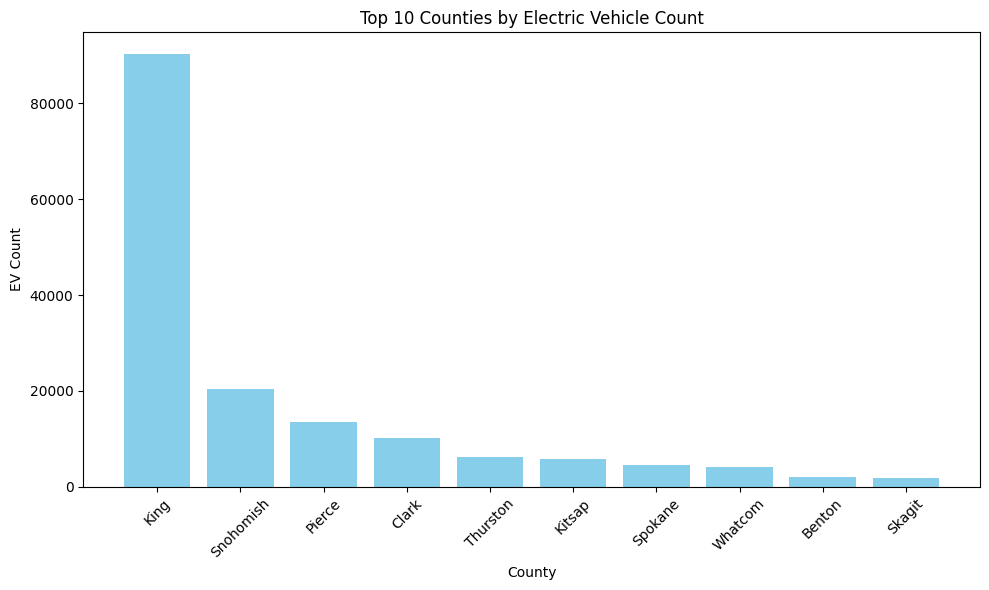

In [ ]:
# EV sayısına göre gruplama ve sayma, ardından Pandas DataFrame'e dönüşüm
county_ev_counts = data.groupBy("County").agg(count("VIN (1-10)").alias("EV_Count"))
county_ev_counts_pd = county_ev_counts.toPandas()

# Pandas DataFrame'i EV sayısına göre sıralama ve ilk 10 ilçeyi seçme
county_ev_counts_pd_sorted = county_ev_counts_pd.sort_values(by='EV_Count', ascending=False).head(10)

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(county_ev_counts_pd_sorted['County'], county_ev_counts_pd_sorted['EV_Count'], color='skyblue')
plt.xlabel('County')
plt.ylabel('EV Count')
plt.xticks(rotation=45)  # Daha iyi okunabilirlik için x eksen etiketlerini döndürme
plt.title('Top 10 Counties by Electric Vehicle Count')
plt.tight_layout()  # Düzeni iyileştirmek için
plt.show()


In [ ]:
data.groupBy("Model Year").agg(count("VIN (1-10)").alias("EV_Count")).orderBy("Model Year").show()


+----------+--------+
|Model Year|EV_Count|
+----------+--------+
|      1997|       1|
|      1998|       1|
|      1999|       4|
|      2000|       7|
|      2002|       2|
|      2003|       1|
|      2008|      20|
|      2010|      22|
|      2011|     776|
|      2012|    1638|
|      2013|    4460|
|      2014|    3532|
|      2015|    4851|
|      2016|    5531|
|      2017|    8599|
|      2018|   14332|
|      2019|   10912|
|      2020|   11696|
|      2021|   19033|
|      2022|   27791|
+----------+--------+
only showing top 20 rows



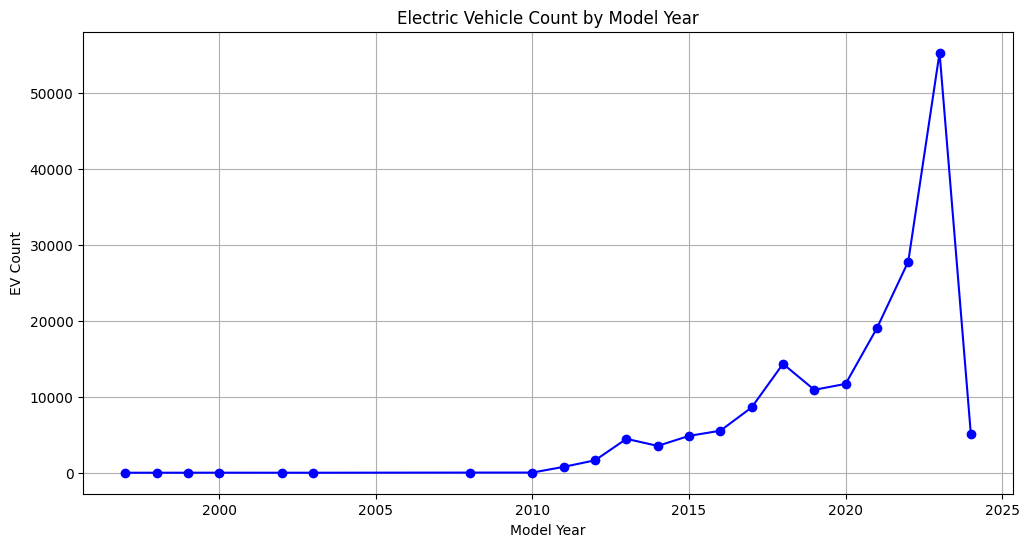

In [ ]:
# Model yılına göre gruplama ve sayma, ardından model yılına göre sıralama
model_year_ev_counts = data.groupBy("Model Year").agg(count("VIN (1-10)").alias("EV_Count")).orderBy("Model Year")

# Sonuçları Pandas DataFrame'e dönüştürme
model_year_ev_counts_pd = model_year_ev_counts.toPandas()

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(model_year_ev_counts_pd['Model Year'], model_year_ev_counts_pd['EV_Count'], marker='o', linestyle='-', color='b')
plt.xlabel('Model Year')
plt.ylabel('EV Count')
plt.title('Electric Vehicle Count by Model Year')
plt.grid(True)
plt.show()

In [ ]:
data.groupBy("Electric Vehicle Type").agg(count("VIN (1-10)").alias("EV_Count")).orderBy("EV_Count", ascending=False).show()


+---------------------+--------+
|Electric Vehicle Type|EV_Count|
+---------------------+--------+
| Battery Electric ...|  135612|
| Plug-in Hybrid El...|   37915|
+---------------------+--------+



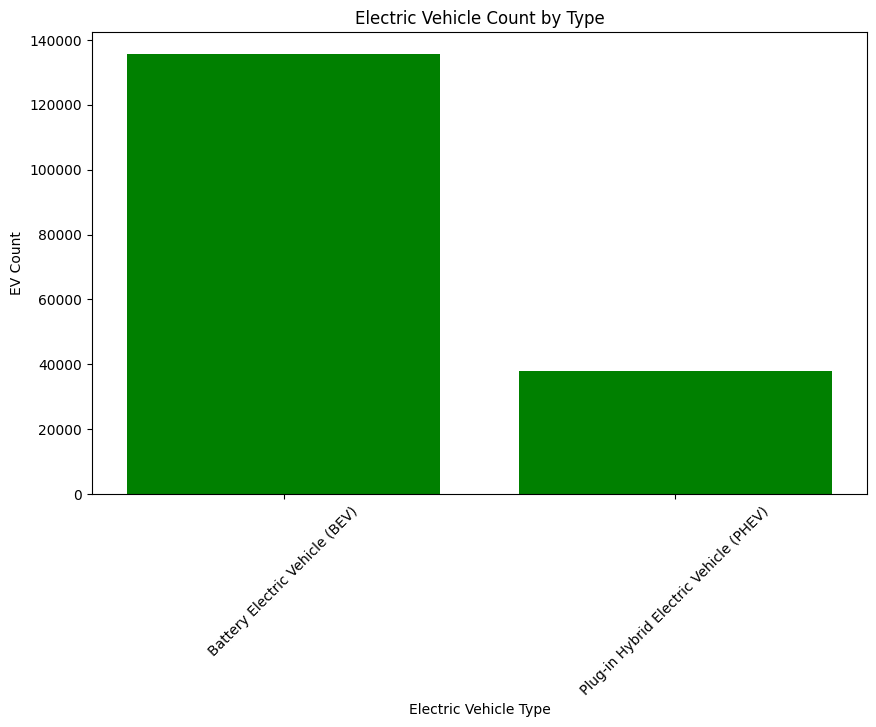

In [ ]:
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt

# Elektrikli araç türüne göre gruplama ve sayma, ardından sayıya göre azalan sıralama
ev_type_counts = data.groupBy("Electric Vehicle Type").agg(count("VIN (1-10)").alias("EV_Count")).orderBy(col("EV_Count").desc())

# Sonuçları Pandas DataFrame'e dönüştürme
ev_type_counts_pd = ev_type_counts.toPandas()

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(ev_type_counts_pd['Electric Vehicle Type'], ev_type_counts_pd['EV_Count'], color='green')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('EV Count')
plt.title('Electric Vehicle Count by Type')
plt.xticks(rotation=45)  # Çubuk etiketlerini okunabilir hale getirmek için döndür
plt.show()


In [ ]:
data.groupBy("Clean Alternative Fuel Vehicle (CAFV) Eligibility").agg(count("VIN (1-10)").alias("EV_Count")).orderBy("EV_Count", ascending=False).show()


+-------------------------------------------------+--------+
|Clean Alternative Fuel Vehicle (CAFV) Eligibility|EV_Count|
+-------------------------------------------------+--------+
|                             Eligibility unkno...|   88302|
|                             Clean Alternative...|   65840|
|                             Not eligible due ...|   19385|
+-------------------------------------------------+--------+



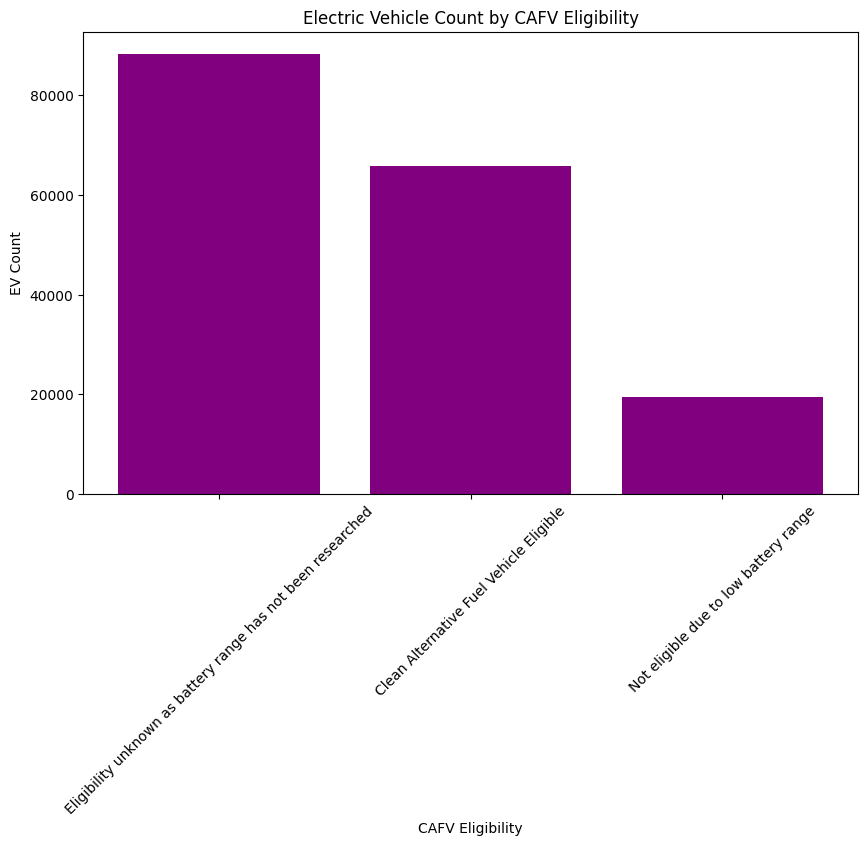

In [ ]:
# CAFV uygunluk durumuna göre gruplama ve sayma, ardından sayıya göre azalan sıralama
cafvs_count = data.groupBy("Clean Alternative Fuel Vehicle (CAFV) Eligibility").agg(count("VIN (1-10)").alias("EV_Count")).orderBy(col("EV_Count").desc())

# Sonuçları Pandas DataFrame'e dönüştürme
cafvs_count_pd = cafvs_count.toPandas()

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(cafvs_count_pd['Clean Alternative Fuel Vehicle (CAFV) Eligibility'], cafvs_count_pd['EV_Count'], color='purple')
plt.xlabel('CAFV Eligibility')
plt.ylabel('EV Count')
plt.title('Electric Vehicle Count by CAFV Eligibility')
plt.xticks(rotation=45)  # Çubuk etiketlerini okunabilir hale getirmek için döndür
plt.show()


In [ ]:
data.groupBy("Postal Code").agg(avg("Electric Range").alias("Average_Range")).orderBy("Average_Range", ascending=False).show()


+-----------+-------------+
|Postal Code|Average_Range|
+-----------+-------------+
|      63137|        322.0|
|       6355|        322.0|
|      60185|        322.0|
|      78412|        322.0|
|       3804|        308.0|
|      20762|        291.0|
|      33131|        291.0|
|      77002|        289.0|
|      30024|        266.0|
|      98164|        266.0|
|      78641|        265.0|
|      50219|        249.0|
|      96734|        238.0|
|      84115|        238.0|
|      89521|        238.0|
|      72207|        236.0|
|      80501|        233.0|
|      71106|        226.5|
|      95661|        220.0|
|      23464|        220.0|
+-----------+-------------+
only showing top 20 rows



In [ ]:
data.groupBy("Model Year").agg(avg("Electric Range").alias("Average_Range_By_Model_Year")).orderBy("Model Year", ascending=True).show()

+----------+---------------------------+
|Model Year|Average_Range_By_Model_Year|
+----------+---------------------------+
|      1997|                       39.0|
|      1998|                       58.0|
|      1999|                       74.0|
|      2000|                       58.0|
|      2002|                       95.0|
|      2003|                       95.0|
|      2008|                      220.0|
|      2010|         225.22727272727272|
|      2011|          70.91623711340206|
|      2012|          61.14590964590965|
|      2013|          80.19103139013453|
|      2014|          81.21177802944507|
|      2015|          98.26035868893011|
|      2016|         101.19182787922618|
|      2017|         113.68473078264914|
|      2018|         155.86415015350266|
|      2019|          177.0737719941349|
|      2020|         238.96913474692204|
|      2021|         11.503178689644303|
|      2022|          4.553452556583067|
+----------+---------------------------+
only showing top

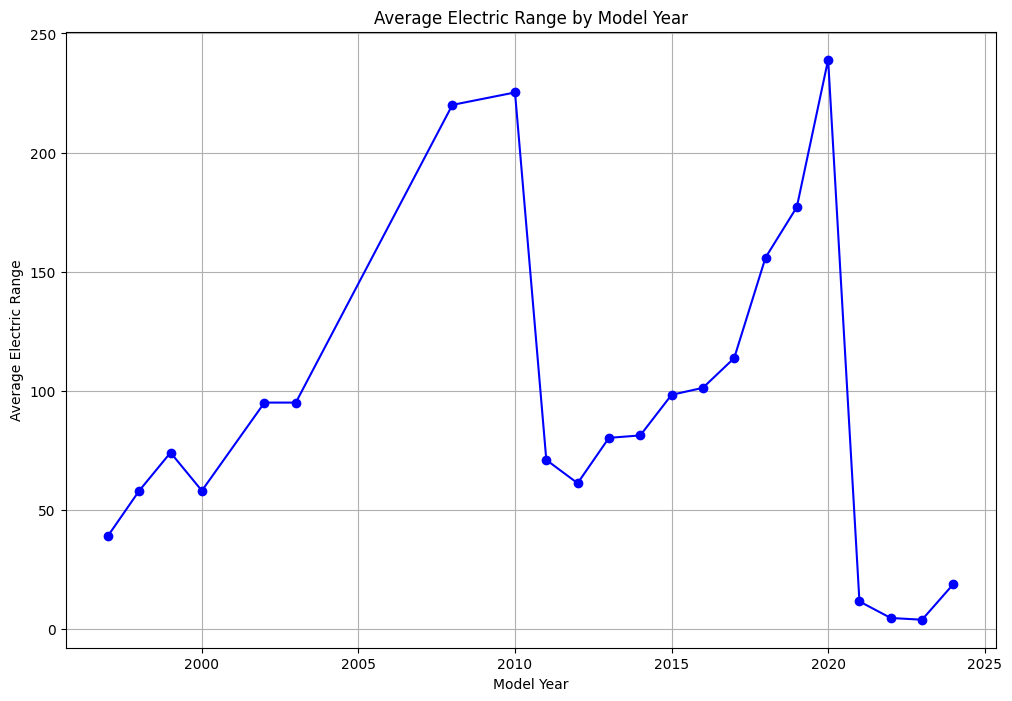

In [ ]:
# Model yılına göre gruplama, ortalama elektrik menzilini hesaplama ve model yılına göre artan sıralama
model_year_avg_range = data.groupBy("Model Year").agg(avg("Electric Range").alias("Average_Range_By_Model_Year")).orderBy(col("Model Year"))

# Sonuçları Pandas DataFrame'e dönüştürme
model_year_avg_range_pd = model_year_avg_range.toPandas()

# Görselleştirme
plt.figure(figsize=(12, 8))
plt.plot(model_year_avg_range_pd['Model Year'], model_year_avg_range_pd['Average_Range_By_Model_Year'], marker='o', linestyle='-', color='blue')
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range')
plt.title('Average Electric Range by Model Year')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import folium

df_pandas = data.select('Vehicle Location').toPandas()


# Koordinat bilgilerini ayıklamak için bir fonksiyon tanımlayalım
def extract_coordinates(point_str):
    try:
        # Parantezleri ve "POINT" kelimesini kaldırarak koordinatları ayırma
        coordinates = point_str.strip("POINT ()").split()
        # Koordinatları float türüne dönüştürme ve sıralamayı (enlem, boylam) olarak ayarlama
        return [float(coordinates[1]), float(coordinates[0])]
    except:
        # Hatalı veya eksik veri durumunda None döndür
        return None

# 'Vehicle Location' sütununu kullanarak koordinatları ayıklama
df_pandas['Coordinates'] = df_pandas['Vehicle Location'].apply(extract_coordinates)

# Koordinatları olan verileri filtreleme (None olmayanlar)
df_pandas_filtered = df_pandas.dropna(subset=['Coordinates'])

# Harita oluşturma (Washington eyaletinin merkezi olan bir noktadan başlayarak)
map = folium.Map(location=[47.7511, -120.7401], zoom_start=6)

# Her bir koordinat için bir nokta ekleyerek haritayı oluşturma
for index, row in df_pandas_filtered.iterrows():
    folium.CircleMarker(location=row['Coordinates'], radius=1, color='blue', fill=True).add_to(map)


In [ ]:
# Haritayı göster
map.save('map.html')